In [103]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 

In [104]:
datos = pd.read_csv("../profiles.csv")
print(datos.shape)
datos.columns

(59946, 31)


Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

# Transformaciones
Quedaron unos variables por transformar
* Separar dos factores
    * educación
    * descendencia
    * mascotas
    * religión
* Hacer las 10 columnas de idiomas   
* Transformar la altura a centimetros
* Transformar los dolares a pesos
* Limpiar las variables essays
* Lidiar con los datos faltantes

## Educación
graduated from, working on, dropped out of; high school, two-year college, university, masters program, law school, med school, Ph.D program, space camp

In [105]:
datos.education.fillna('',inplace=True)

factor1 = ["graduated from", "working on", "dropped out of"]
factor2 = ["high school", "two-year college", "university", "masters program", 
           "law school", "med school", "ph.d program", "space camp"]

datos.education = datos.education.map(lambda s:s.replace("college/university","university"))

datos["education_status"] = datos.education.copy()
datos["education_level"] = datos.education.copy()

for status in factor1:
    datos.education_status = datos.education_status.map(lambda s:status if status in s else s)
    
for level in factor2:
    datos.education_level = datos.education_level.map(lambda s:level if level in s else s)

## Descendencia
tiene_hijos
* doesn't have kids:0
* has a kid:1
* has kids:2

quiere_hijos
* no (doesn't want more, doesn't want any):0
* and might want more: 1
* si (and wants them, but wants them): 2

In [106]:
datos.offspring.fillna('',inplace=True)
datos.offspring = datos.offspring.map(lambda s:s.replace("doesn&rsquo;t","doesn't"))
datos.offspring.unique()

array(["doesn't have kids, but might want them", '', "doesn't want kids",
       "doesn't have kids, but wants them", "doesn't have kids",
       'wants kids', 'has a kid', 'has kids',
       "doesn't have kids, and doesn't want any",
       "has kids, but doesn't want more",
       "has a kid, but doesn't want more", 'has a kid, and wants more',
       'has kids, and might want more', 'might want kids',
       'has a kid, and might want more', 'has kids, and wants more'],
      dtype=object)

In [107]:
tiene_hijos = {"doesn't want kids":0,"doesn't have kids":0,"has a kid":1,"has kids":2}
quiere_hijos = {"doesn't want kids":0,"doesn't want more":0, "doesn't want any":0,
                "might want more":1, "might want them":1,
                "wants them":2, "wants more":2}

# -1 es que no quiso decir (no hay info)
datos["tiene_hijos"] = -1
datos["quiere_hijos"] = -1

for status,v in tiene_hijos.items():
    rows = datos.offspring.map(lambda x:status in x)
    datos.loc[rows,"tiene_hijos"] = v
    
for status,v in quiere_hijos.items():
    rows = datos.offspring.map(lambda x:status in x)
    datos.loc[rows,"quiere_hijos"] = v

## Mascotas

In [108]:
# pets -> dogs: {-1:"no le gustan",0:nada, 1:le gustan, 2:tiene}

gustos = {"not":-1, "likes":1, "has":2}
datos["dogs"] = 0.0
datos["cats"] = 0.0

datos.pets.fillna('',inplace=True)
datos.pets = datos.pets.map(lambda s:s.replace("dislikes","not"))

for pet in ["dogs","cats"]:
    #rows = datos.pets.map(lambda s:pet in s)
    for gusto,value in gustos.items():
        rows = datos.pets.map(lambda s:all(h in s for h in [gusto,pet]))
        datos.loc[rows,pet] = value 

## Religión
agnosticism, atheism, Christianity, Judaism, Catholicism, Islam, Hinduism, Buddhism, Other; and very serious about it, and somewhat serious about it, but not too serious about it, and laughing about it

In [109]:
datos.religion.fillna('', inplace=True)

religiones = ["agnosticism", "atheism", "christianity", "judaism",
              "catholicism","islam","hinduism","buddhism","other"]

seriedad = {"and laughing about it":0.,
            "but not too serious about it":1.,
            "and somewhat serious about it":2.,
            "and very serious about it":3.}

datos["creencia"] = ''
for religion in religiones:
    rows = datos.religion.map(lambda s:religion in s)
    datos.loc[rows,"creencia"] = religion
    
datos["creencia_importancia"] = 1. # Asumiremos que en promedio la gente no se toma muy en serio la religión
for niv,v in seriedad.items():
    rows = datos.religion.map(lambda s:niv in s)
    datos.loc[rows,"creencia_importancia"] = v

## Idiomas

In [110]:
import time
t0 = time.time()
for i in range(5):
    datos[f"idioma_nombre{i}"] = "No aplica"
    datos[f"idioma_nivel{i}"]= -1

idiomas = datos.speaks.map(lambda s:s.split(','), na_action="ignore")
niveles = {"poorly":0, "okay":1, "fluently":2}

for i,item in idiomas.iteritems():
    if type(item) is list:
        for k,language in enumerate(item):
            tupla = language.split()
            datos.loc[i,f"idioma_nombre{k}"] = tupla[0]
            if len(tupla) > 1:
                if "poorly" in tupla[1]:
                    niv = 0
                elif "okay" in tupla[1]:
                    niv = 1
                else:
                    niv = 2
                datos.loc[i,f"idioma_nivel{k}"] = niv
                
time.time()-t0

422.0790500640869

## Altura

In [111]:
# Transformaciones numéricas
datos.height = datos.height*2.54
datos.height.fillna(datos.height.median(),inplace=True)

## Ingresos

In [112]:
datos.income = datos.income*24
datos.loc[datos.income < 0,"income"] = -1

## Descripciones

In [113]:
def limpiar_essay(s):
    s = s.strip().replace('\n',' ').replace("<br />",'')
    # Quitando los tags HTML
    s = re.sub("<\s*a[^>]*>",'',s)
    s = re.sub("<\s*/\s*a>",'',s)
    return s

In [114]:
essays = [f"essay{i}" for i in range(10)]
for essay in essays:
    datos[essay] = datos[essay].map(limpiar_essay, na_action="ignore")

## Quitando columnas
Ahora que ya hicimos las transformaciones que se mencionaron, las columnas originales pueden ser omitidas

In [116]:
datos.drop(columns=["education","offspring","pets","speaks"],inplace=True)
datos.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'essay0', 'essay1',
       'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8',
       'essay9', 'ethnicity', 'height', 'income', 'job', 'last_online',
       'location', 'orientation', 'religion', 'sex', 'sign', 'smokes',
       'status', 'education_status', 'education_level', 'tiene_hijos',
       'quiere_hijos', 'dogs', 'cats', 'creencia', 'creencia_importancia',
       'idioma_nombre0', 'idioma_nivel0', 'idioma_nombre1', 'idioma_nivel1',
       'idioma_nombre2', 'idioma_nivel2', 'idioma_nombre3', 'idioma_nivel3',
       'idioma_nombre4', 'idioma_nivel4'],
      dtype='object')

## Lidiando con datos faltantes NaNs

Llenaremos los datos faltantes con el dato que se repite más veces.

Las descripciones (essays) no hará falta llenarlo, pues no se considerará para hacer análisis de características importantes

In [117]:
datos.isna().sum(axis=0) > 0

age                     False
body_type                True
diet                     True
drinks                   True
drugs                    True
essay0                   True
essay1                   True
essay2                   True
essay3                   True
essay4                   True
essay5                   True
essay6                   True
essay7                   True
essay8                   True
essay9                   True
ethnicity                True
height                  False
income                  False
job                      True
last_online             False
location                False
orientation             False
religion                False
sex                     False
sign                     True
smokes                   True
status                  False
education_status        False
education_level         False
tiene_hijos             False
quiere_hijos            False
dogs                    False
cats                    False
creencia  

In [118]:
datos.body_type.fillna(datos.body_type.mode()[0], inplace=True)

In [119]:
datos.diet.fillna(datos.diet.mode()[0], inplace=True)

In [120]:
datos.drinks.fillna(datos.drinks.mode()[0], inplace=True)

In [121]:
datos.drugs.fillna(datos.drugs.mode()[0],inplace=True) # never

In [122]:
datos.ethnicity.fillna(datos.ethnicity.mode()[0],inplace=True)

In [123]:
datos.job.fillna(datos.job.mode()[0],inplace=True) # never

In [124]:
datos.sign.fillna(datos.sign.mode()[0],inplace=True) # no

In [125]:
datos.smokes.fillna(datos.smokes.mode()[0],inplace=True) # no

In [136]:
datos.essay0.fillna('',inplace=True)

In [126]:
# Verificación
datos.isna().sum(axis=0)

age                         0
body_type                   0
diet                        0
drinks                      0
drugs                       0
essay0                   5488
essay1                   7572
essay2                   9638
essay3                  11476
essay4                  10537
essay5                  10850
essay6                  13771
essay7                  12451
essay8                  19225
essay9                  12603
ethnicity                   0
height                      0
income                      0
job                         0
last_online                 0
location                    0
orientation                 0
religion                    0
sex                         0
sign                        0
smokes                      0
status                      0
education_status            0
education_level             0
tiene_hijos                 0
quiere_hijos                0
dogs                        0
cats                        0
creencia  

In [24]:
datos.status.unique()

array(['single', 'available', 'seeing someone', 'married', 'unknown'],
      dtype=object)

In [128]:
datos.status = datos.status.map({"unknown":0,"single":1,"available":2,"seeing someone":3,"married":4})

# Preparando los datos para análisis

In [248]:
variables = ["age", "income", "height", "body_type", "diet", "drinks", "drugs", 
             "ethnicity","job", "location", "orientation", "sex", "sign",
             "smokes", "education_status", "education_level", "tiene_hijos",
             "quiere_hijos", "dogs", "cats", "creencia", "creencia_importancia",
             "idioma_nombre0", "idioma_nivel0", "idioma_nombre1", "idioma_nivel1",
             "idioma_nombre2", "idioma_nivel2", "idioma_nombre3", "idioma_nivel3",
             "idioma_nombre4", "idioma_nivel4"]

X = datos[variables]
y = datos["status"].values

In [249]:
X1 = X[["age","income","height"]]
X2 = X.drop(columns="age income height".split())
X2 = OrdinalEncoder().fit_transform(X2)
X = np.hstack([X1.values,X2])

# Análisis

Cómo encontrar el amor...
Ver que características son las importantes


In [428]:
sel = SelectKBest(k=7)
sel.fit(X,y)
np.array(variables)[sel.get_support()]

array(['age', 'drugs', 'orientation', 'tiene_hijos', 'dogs', 'cats',
       'idioma_nivel0'], dtype='<U20')

In [29]:
rows = datos.status.isin([2,3])
vars_ = list( np.array(variables)[sel.get_support()] )
luv = datos.loc[rows,vars_]

# Visualizaciones

In [473]:
int2status = ["Desconocido","Soltero","Disponible","Viendo a alguien","Casado"]
datos_de = {i:datos.loc[(datos.status==i) & (datos.age <=80)] for i in range(1,5)}

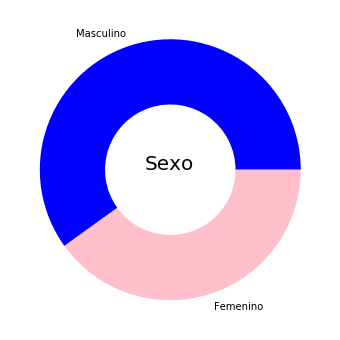

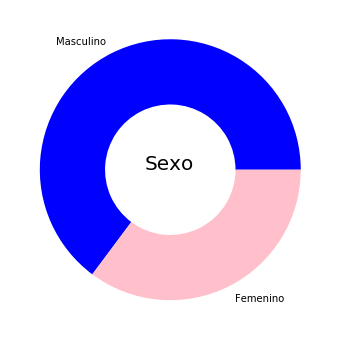

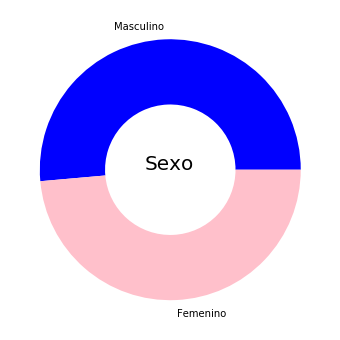

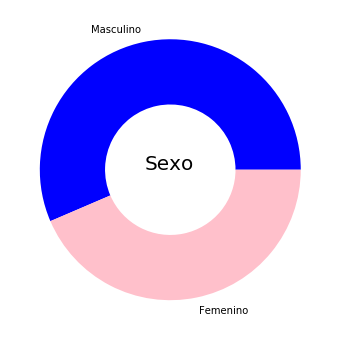

In [474]:
for i,df in datos_de.items():
    info = df.sex.map({'f':0,'m':1}).value_counts()
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    info.plot.pie(ax=ax, wedgeprops = {'width':0.5}, labels=["Masculino","Femenino"],colors=["blue","pink"])
    ax.set_ylabel('')
    ax.text(-0.2,0,"Sexo",fontsize=20)
    fig.savefig(f"../img/sex{i}.png", bbox_inches="tight",transparent=True)

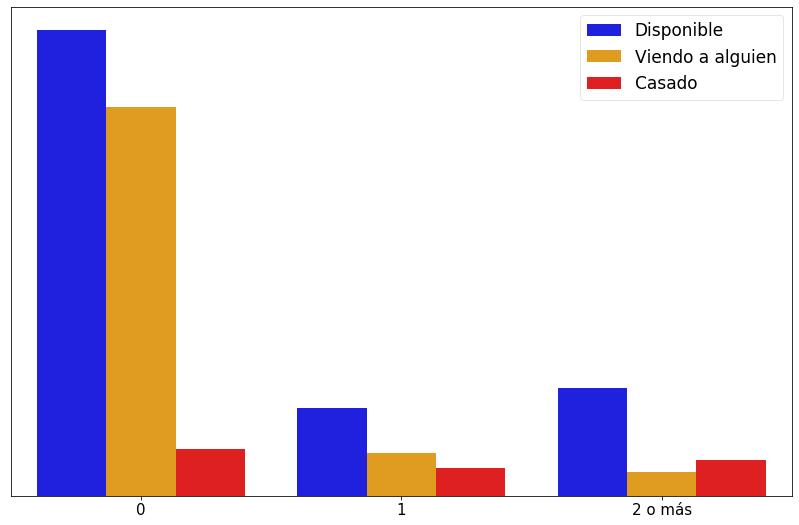

In [475]:
conteo = datos.groupby("status tiene_hijos".split()).agg(["count"])["age"]
conteo.reset_index(inplace=True)
conteo.tiene_hijos = conteo.tiene_hijos.map({0:"0",1:"1",2:"2 o más"})
conteo = conteo.loc[(conteo.status.isin([2,3,4]))&(conteo.tiene_hijos != -1),:]
conteo.status = conteo.status.map({i:status for i,status in enumerate(int2status)})

fig, ax = plt.subplots(1,1,figsize=(14,9))
sns.barplot(data=conteo,hue="status",x="tiene_hijos",y="count",ax=ax,palette=["blue","orange","red"])
ax.set_ylabel('')
ax.set_yticks([])
ax.legend(fontsize=17,fancybox=True, framealpha=0.5)
ax.set_xlabel("",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(f"../img/tiene_hijos.png", bbox_inches="tight",transparent=True)

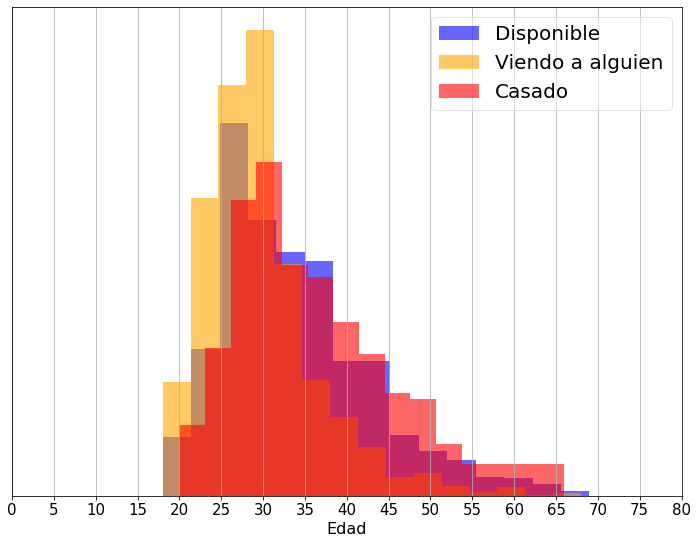

In [476]:
fig, ax = plt.subplots(1,1,figsize=(12,9))
for i in [2,3,4]:
    df = datos_de[i]
    status = int2status[i]
    if i == 2:
        α = 0.6 # No destacar a los que andan "solos"
        color = "blue"
    elif i == 3:
        α = 0.6
        color = "orange"
    else:
        α = 0.6
        color="red"
    sns.distplot(df.age,bins=15,color=color,ax=ax,label=status,
                 hist_kws={"alpha":α},kde=False,hist=True,norm_hist=True)
    
ax.legend(fontsize=20,fancybox=True, framealpha=0.5)
ax.set_xlabel("Edad",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticks(np.arange(85,step=5))
ax.set_yticks([])
ax.grid()
fig.savefig(f"../img/edad.png", bbox_inches="tight",transparent=True)

Quizás sea verdad que para el amor no hay edad
(las distribuciones de edad son casi proporcionales)

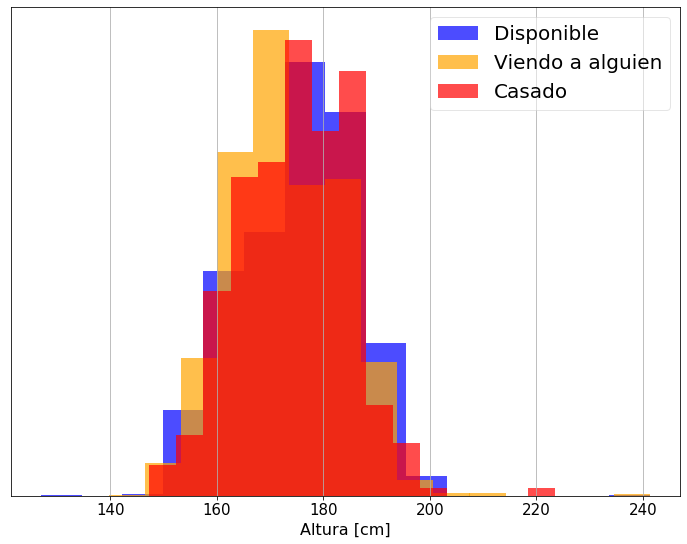

In [477]:
fig, ax = plt.subplots(1,1,figsize=(12,9))
for i in [2,3,4]:
    df = datos_de[i]
    status = int2status[i]
    if i == 2:
        α = 0.7 # No destacar a los que andan "solos"
        color = "blue"
    elif i == 3:
        α = 0.7
        color = "orange"
    else:
        α = 0.7
        color="red"
    sns.distplot(df.height,bins=15,color=color,ax=ax,label=status,
                 hist_kws={"alpha":α},kde=False,hist=True,norm_hist=True)
    
ax.legend(fontsize=20,fancybox=True, framealpha=0.5)
ax.set_xlabel("Altura [cm]",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yticks([])
ax.grid()
fig.savefig(f"../img/altura.png", bbox_inches="tight",transparent=True)

In [478]:
conteo_cuerpos = datos.groupby("body_type status".split()).agg(["count"])["age"]
#conteo_cuerpos.reset_index(inplace=True)

# congregando personas
conteo_cuerpos.loc["a little extra"] = (conteo_cuerpos.loc["a little extra"]+conteo_cuerpos.loc["curvy"]).values
conteo_cuerpos.loc["thin"] = (conteo_cuerpos.loc["thin"]+conteo_cuerpos.loc["skinny"]).values
conteo_cuerpos.loc["fit"] = (conteo_cuerpos.loc["fit"]+conteo_cuerpos.loc["athletic"] + conteo_cuerpos.loc["jacked"]).values

conteo_cuerpos.drop(labels=["curvy","skinny","athletic","jacked"]+["rather not say","used up","full figured"],inplace=True)
conteo_cuerpos["count"].fillna(0,inplace=True)
conteo_cuerpos.reset_index(inplace=True)
conteo_cuerpos.body_type = conteo_cuerpos.body_type.map({"a little extra":"Un poco pasado", "fit":"fit",
                                                           "athletic":"atlético","average":"promedio",
                                                           "overweight":"sobrepeso","thin":"delgado"})

conteo_cuerpos.status = conteo_cuerpos.status .map({i:status for i,status in enumerate(int2status)})
conteo_cuerpos

,body_type,status,count
0,Un poco pasado,Desconocido,2.0
1,Un poco pasado,Soltero,5953.0
2,Un poco pasado,Disponible,259.0
3,Un poco pasado,Viendo a alguien,284.0
4,Un poco pasado,Casado,55.0
5,promedio,Desconocido,6.0
6,promedio,Soltero,18329.0
7,promedio,Disponible,648.0
8,promedio,Viendo a alguien,833.0
9,promedio,Casado,132.0


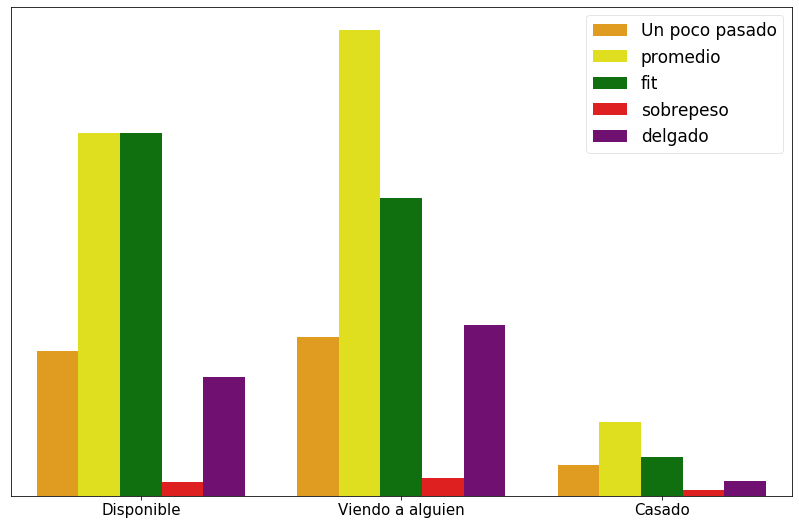

In [479]:
conteo_cuerpos2 = conteo_cuerpos.loc[conteo_cuerpos.status.isin(["Disponible","Viendo a alguien","Casado"])]
fig, ax = plt.subplots(1,1,figsize=(14,9))
sns.barplot(data=conteo_cuerpos2,hue="body_type",x="status",y="count",ax=ax,palette=["orange","yellow","green","red","purple"])
ax.set_ylabel('')
ax.set_yticks([])
ax.legend(fontsize=17,fancybox=True, framealpha=0.5)
ax.set_xlabel("",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(f"../img/cuerpo.png", bbox_inches="tight",transparent=True)

In [480]:
conteo = datos.groupby("status dogs".split()).agg(["count"])["age"]
conteo.reset_index(inplace=True)
conteo.dogs = conteo.dogs.map({-1:"No le gustan",0:"Meh",1:"Le gustan",2:"Tienen"})
conteo = conteo.loc[conteo.status.isin([2,3,4]),:]
conteo.status = conteo.status.map({i:status for i,status in enumerate(int2status)})

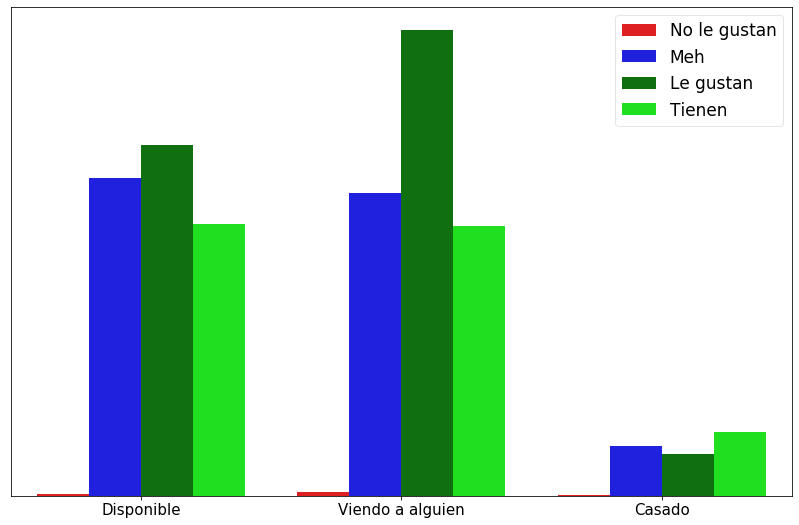

In [481]:
fig, ax = plt.subplots(1,1,figsize=(14,9))
sns.barplot(data=conteo,hue="dogs",x="status",y="count",ax=ax,palette=["red","blue","green","lime"])
ax.set_ylabel('')
ax.set_yticks([])
ax.legend(fontsize=17,fancybox=True, framealpha=0.5)
ax.set_xlabel("",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(f"../img/perros.png", bbox_inches="tight",transparent=True)

In [482]:
conteo = datos.groupby("status cats".split()).agg(["count"])["age"]
conteo.reset_index(inplace=True)
conteo.cats = conteo.cats.map({-1:"No le gustan",0:"Meh",1:"Le gustan",2:"Tienen"})
conteo = conteo.loc[conteo.status.isin([2,3,4]),:]
conteo.status = conteo.status.map({i:status for i,status in enumerate(int2status)})

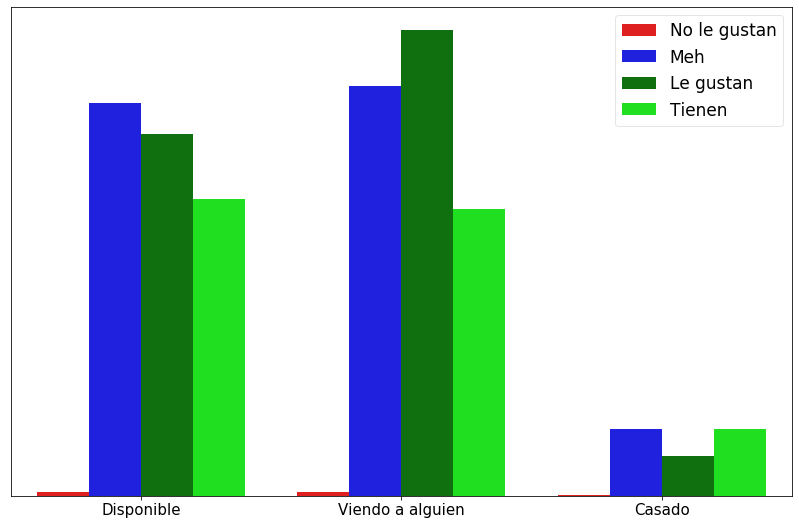

In [486]:
fig, ax = plt.subplots(1,1,figsize=(14,9))
sns.barplot(data=conteo,hue="cats",x="status",y="count",ax=ax,palette=["red","blue","green","lime"])
ax.set_ylabel('')
ax.set_yticks([])
ax.legend(fontsize=17,fancybox=True, framealpha=0.5)
ax.set_xlabel("",fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(f"../img/gatos.png", bbox_inches="tight",transparent=True,dpi=700)

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


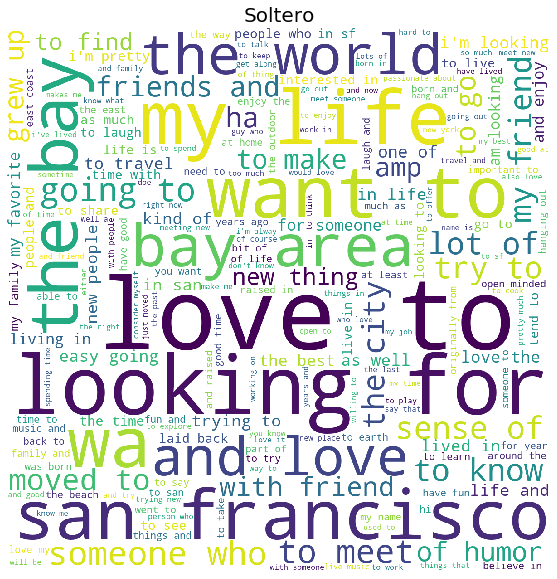

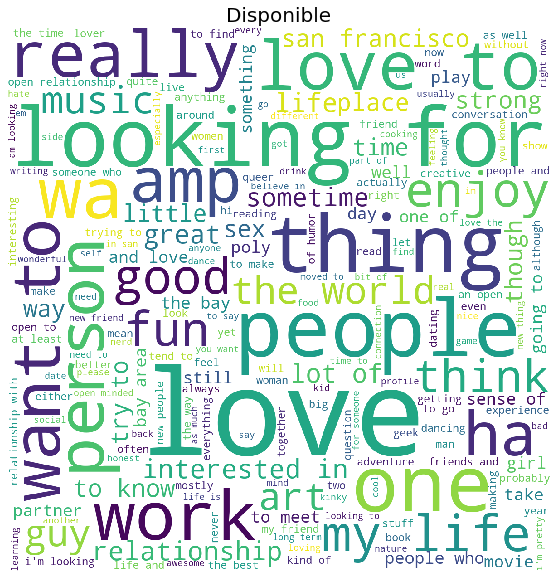

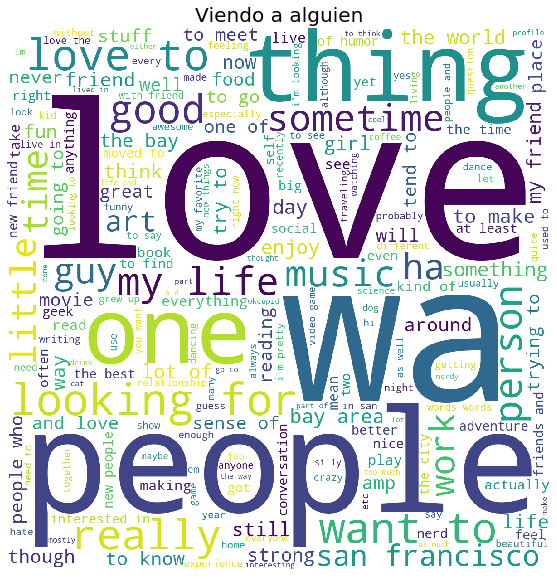

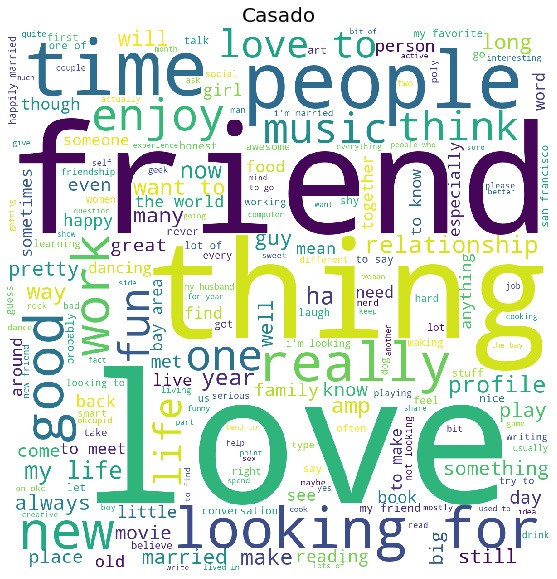

In [487]:
for i,df in datos_de.items():
    df.essay0.fillna('',inplace=True)
    texto = ''.join(df.essay0.to_list())
    nube = WordCloud(width = 1200, height = 1200, 
                    background_color ='white', 
                    stopwords = STOPWORDS, 
                    min_font_size = 10).generate(texto)

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.set_axis_off()
    ax.set_title(int2status[i],fontsize=20)
    ax.imshow(nube)
    fig.savefig(f"../img/nube_bio{i}.png", bbox_inches="tight",transparent=True)

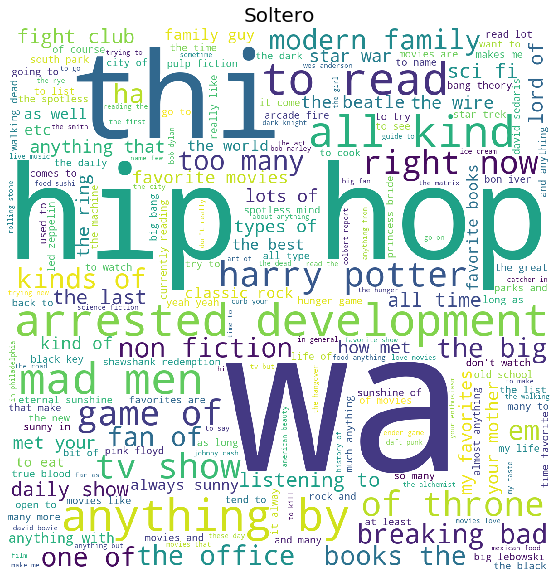

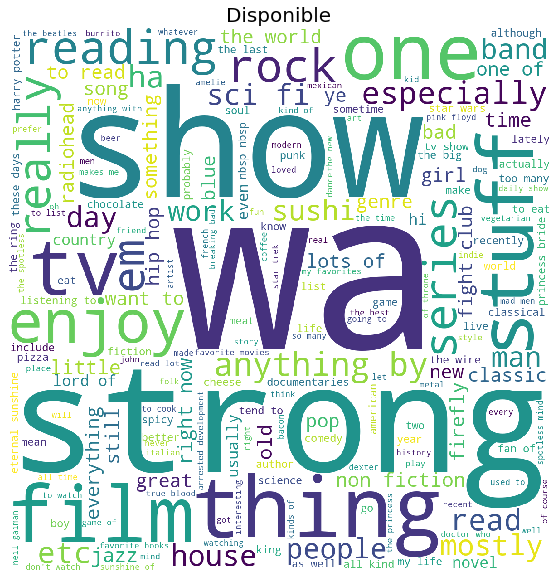

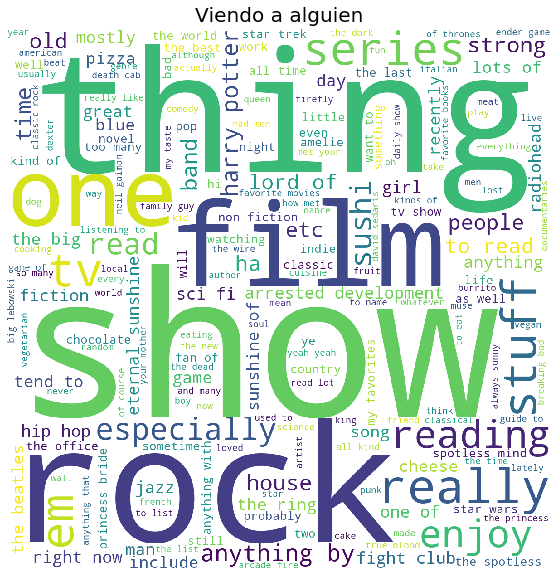

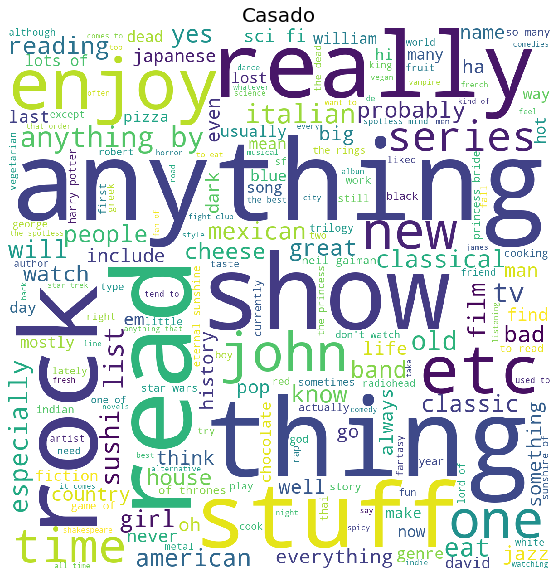

In [488]:
stopwords = STOPWORDS | set("""favorite love movie book music lot of pretty much 
                                listen to good food though amp""".split())
for i,df in datos_de.items():
    df.essay4.fillna('',inplace=True)
    texto = ''.join(df.essay4.to_list())
    nube = WordCloud(width = 1200, height = 1200, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(texto)

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.set_axis_off()
    ax.set_title(int2status[i],fontsize=20)
    ax.imshow(nube)
    fig.savefig(f"../img/nube_gustos{i}.png", bbox_inches="tight",transparent=True)